# Basic object detection

## Intro

Training một model object detection thông thường sẽ bao gồm các bước sau:

1. Tạo ground truth data có chứa labels của bounding box và class của các object có trong ảnh
2. Scan qua ảnh để xác định các vùng ảnh có khả năng chứa object
3. Tạo target class sử dụng IoU 
4. Tạo target bounding box offset để xác định chính xác location của vùng ảnh xác định ở bước 2
5. Xây dựng model để dự đoán đối tượng vùng ảnh được bao bởi bounding box
6. Tính toán accuracy của object detection sử dụng `mean Average Precision (mAP)`

## 1. Creating a bounding box ground truth for training

Điều mà chúng ta mong muốn trong object detection đó là cho ảnh đầu vào => ảnh đầu ra là bức ảnh với bounding box bao quanh vật thể trong ảnh và nhãn của vật thể đó (là vật thể gì, vũ khí, điện thoại ...)

Do vậy điều chúng ta cần làm là thực hiện tập train data với ảnh đầu vào và một file labels chứa class của vật thể xác định được trong ảnh cùng với tọa độ của bounding box bao lấy vật thể (tâm (x, y), chiều dài, chiều rộng)

### Sử dụng tool để vẽ bounding box làm tập train

## 2. Understanding region proposals

**Region proposal** là một kĩ thuật giúp xác định ra các vùng ảnh có pixels gần giống nhau.



## 3. Leveraging SelectiveSearch to generate region proposals

`SelectiveSearch` là một thuật toán `region proposal` sử dụng cho object localiztion bằng cách group các vùng ảnh có intensities gần nhau lại thành một vùng.

![](../../../imgs/selective_search_1.png)


Ta có thể tận dụng thuật toán này để tạo ra các region proposals. Ý tưởng là ta sẽ dùng `selectivesearch.selective_search()` để lấy ra các vùng ảnh ứng viên. So sánh với Area của ảnh => ta chỉ giữ lại các vùng ảnh có kích thước `5% * img_area < region < 100% * img_area`

In [4]:
import selectivesearch
from torch_snippets import *
import numpy as np

def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, \
                                                        scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates


[
    [0, 0, 140, 294],
    [212, 0, 85, 409],
    [160, 218, 84, 271],
    [68, 269, 80, 228],
    [222, 266, 68, 249],
    [57, 43, 168, 123],
    [160, 218, 84, 271],
    [57, 0, 168, 166],
    [212, 0, 85, 409],
    [222, 266, 74, 249],
    [0, 269, 148, 228],
    [158, 218, 86, 271],
    [54, 0, 171, 170],
    [161, 193, 135, 322],
    [54, 0, 171, 170],
    [158, 218, 86, 271],
    [54, 0, 171, 170],
    [212, 0, 87, 464],
    [0, 264, 148, 233],
    [161, 193, 138, 322],
    [53, 125, 169, 166],
    [212, 0, 87, 464],
    [0, 131, 148, 366],
    [0, 0, 140, 294],
    [158, 218, 86, 271],
    [158, 193, 141, 322],
    [54, 0, 171, 170],
    [0, 131, 148, 366],
    [0, 0, 148, 294],
    [32, 271, 231, 244],
    [0, 131, 148, 366],
    [54, 0, 245, 464],
    [0, 271, 263, 244],
    [0, 131, 148, 366],
    [53, 104, 169, 187],
    [53, 104, 169, 187],
    [0, 0, 148, 497],
    [0, 271, 263, 244],
    [0, 271, 263, 244],
    [0, 271, 263, 244],
    [0, 104, 263, 411],
    [158, 193, 141, 322],
    [0, 0, 148, 497],
    [0, 0, 148, 497],
    [0, 104, 263, 411],
    [0, 104, 299, 411],
    [0, 0, 299, 515],
    [54, 0, 245, 464],
    [0, 0, 299, 515]
]

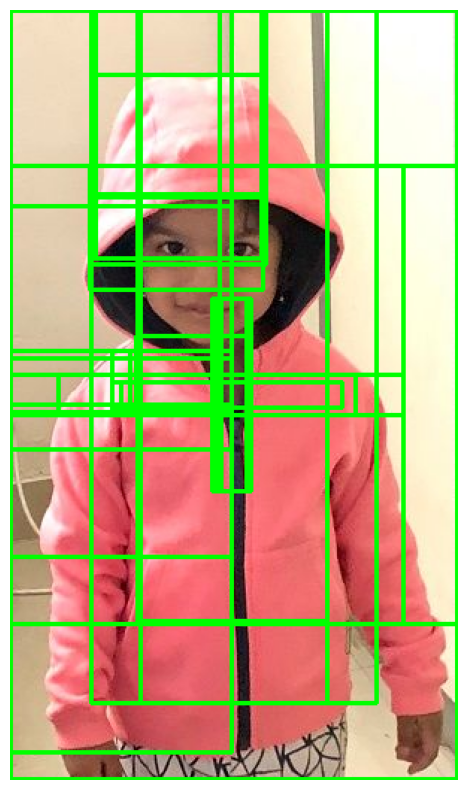

In [5]:
img = read('Hemanvi.jpeg', 1)

candidates = extract_candidates(img)
print(candidates)

show(img, bbs=candidates)

Từ các vùng ảnh được xác định trên ta có thể tận dụng để phục vụ cho object detection và object localization bằng cách là đi so sảnh chỉ số IoU của các region tìm được với ground truth ( vùng chứa vật thể cần xác định đã được đánh nhãn cho training). Nếu như chỉ số IoU > threshold (một ngưỡng nào đó) thì vùng đó được coi là vùng chứa vật thể, ngược lại thì sẽ được coi là vùng background (k chứa vật thể)

## 4. Chỉ số IoU

Stand for `Intersection over Union (IoU)`. Chỉ số này đại diện cho mức độ trùng nhau (overlapping) của bounding box dự đoán so với bounding box thực tế (đưuọc đánh nhãn để training).

<div style="display:flex;">
    <img src="../../../imgs/iou_1.png"/>
    <img src="../../../imgs/iou_2.png"/>
</div>

Hàm tính iou dưới đây có thêm chỉ số epsilon để tránh trường hợp `area_combined = 0` => lỗi chia cho 0

In [7]:
def get_iou(boxA, boxB, epsilon=1e-5):
    # Tìm ra vùng union bằng cách xác định điểm trên cùng bên trái vs điểm dưới cùng bên phải
    # Điểm trên cùng bên trái
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    
    # Điểm dưới cùng bên phải
    x2 = max(boxA[2], boxB[2])
    y2 = max(boxA[3], boxB[3])
    
    # tính width height của vùng đè lên nhau
    width = (x2 - x1)
    height = (y2 - y1)
    
    # Tính diện tích vùng đè lên nhau:
    if( width < 0) or (height < 0):
        return 0.0
    area_overlap = width * height
    
    # Tính union area (combined area)
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    
    iou = area_overlap / (area_combined + epsilon)
    return iou

## 5. Non-max suppression

Vấn đề đặt ra đó là khi thực hiện lấy ra được các region proposals ( đã thỏa mãn ngưỡng), ta thu được rất nhiều các box gần vật thể bao quanh lên nhau, ví dụ như ảnh dưới:

<figure>
  <img src="../../../imgs/non_max_1.png" alt="">
  <figcaption>Fig.1 - Many boudning box.</figcaption>
</figure>

Vậy nhiệm vụ của ta bây giờ sẽ là xác định ra box nào là box bao vật thể đúng nhất => Sử dụng `Non-max suppression`

- `Non-max` là các box có probability containing object là thấp.
- `suppression` là loại bỏ đi các `non-max` box.

Vậy `Non-max suppression` là ta sẽ đi tìm ra các box có xác suất chứa object lớn nhất, sau đó so sánh nó với các box còn lại để loại bỏ đi các box có (IoU) gần với nó nhất => thực hiện lặp lại quá trình này sẽ lấy ra được các bounding box trong ảnh.

Việc sử dụng `Non-max suppression` trong pytorch là sử dụng hàm `nms` trong module `torchvision.ops`.

## 6. Mean average precision (mAP)

`mAP` là chỉ số để đánh giá model object detection hoạt động tốt hay không.

### Precision

$$Precision = \dfrac{True positives}{(True positives + False positives)}$$

### Average Precision

Là giá trị trung bình của `Precision` tính toán trên các `IoU thresholds` khác nhau

### mAP

Là giá trị precision trung bình tính toán trên các `IoU threshold` khác nhau và trên toàn bộ các classes of objects trong tập dataset

## 7. Training R-CNN-based custom object detectors

<figure>
    <img src="../../../imgs/r-cnn-1.png"/>
    <figcaption>Image source: <a href="https://arxiv.org/pdf/1311.2524.pdf">https://arxiv.org/pdf/1311.2524.pdf</a></figcaption>
</figure>

R-CNN technique theo các bước sau:

1. Extract region proposals từ image. Thường thì số lượng region proposal rất lớn để tránh miss chút nào object trong ảnh (~2k region)
2. Resize các region về cùng size
3. Đưa các resized region qua CNN, thường là các pretrained CNN như VGG16 hay ResNet50 và extract các features ra fully connected layer
4. Tạo data để training model với inputs là các features extracted từ pretrained model của các region proposals và outputs là class cùng với tọa độ của box
    - Nếu như region proposal có `IoU` cao hơn một ngưỡng nhất định so với object, ta sẽ prepare training data với mục đích để region này đóng vai trò trong việc xác định class của object mà nó overlapping cùng với tọa độ của bounding box 

    Ví dụ:

    ![](../../../imgs/r-cnn-2.png)

    Ảnh trên biểu diễn box màu đỏ với chấm tròn là region proposal và tâm của nó, còn box màu vàng với chấm x là gound truth bounding box mà ta đã gán nhãn phục vụ training. Ta sẽ tính toán độ lệch giữa 2 box này dự trên độ lệch giữa tâm cùng với chiều dài, chiều rộng của chúng.

5. Kết hợp 2 output là class và tọa độ bounding box
6. Train model, viết custom loss function.

## 8. Implementing R-CNN for object detection on a custom dataset

1. Tải dataset về
2. Preparing dataset
3. Define hàm extract region proposals và IoI
4. Tạo training data
    - Tạo input data cho model
        - Resizing region proposals
        - Passing các region proposal qua pretrained model để lấy ra các fully connected layer values
    - Tạo output data cho model
        - đánh nhãn cho các region proposal
        - defining offset của region proposal từ round truth nếu region proposal tương ứng với object không phải background
5. Defining và training model
6. Thực hiện dự đoán trên images mới

In [26]:
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
from torch_snippets import Report
from torchvision.ops import nms
import numpy as np

download data

In [3]:
!kaggle datasets download -d sixhky/open-images-bus-trucks/


  0%|          | 0.00/367M [00:00<?, ?B/s]
  0%|          | 1.00M/367M [00:01<07:24, 863kB/s]
  1%|          | 2.00M/367M [00:02<06:22, 1.00MB/s]
  1%|          | 3.00M/367M [00:03<06:09, 1.03MB/s]
  1%|          | 4.00M/367M [00:04<06:24, 988kB/s] 
  1%|▏         | 5.00M/367M [00:05<05:43, 1.11MB/s]
  2%|▏         | 6.00M/367M [00:06<06:31, 967kB/s] 
  2%|▏         | 7.00M/367M [00:07<07:35, 828kB/s]
  2%|▏         | 8.00M/367M [00:09<08:28, 739kB/s]
  2%|▏         | 9.00M/367M [00:12<10:28, 597kB/s]
  3%|▎         | 10.0M/367M [00:14<11:05, 562kB/s]
  3%|▎         | 11.0M/367M [00:17<12:39, 491kB/s]
  3%|▎         | 12.0M/367M [00:20<15:43, 394kB/s]
  4%|▎         | 13.0M/367M [00:27<22:08, 279kB/s]
  4%|▍         | 14.0M/367M [00:33<26:36, 232kB/s]
  4%|▍         | 15.0M/367M [00:40<30:52, 199kB/s]
  4%|▍         | 16.0M/367M [00:48<35:12, 174kB/s]
  5%|▍         | 17.0M/367M [00:58<43:11, 142kB/s]
  5%|▍         | 18.0M/367M [01:04<40:22, 151kB/s]
  5%|▌         | 19.0M/367M [01:1

In [14]:
!tar -xf "open-images-bus-trucks.zip"

In [44]:
import pandas as pd
import requests
import io

# DOWNLOAD_URL = 'https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv'
DOWNLOAD_URL = './df.csv'

# s = requests.get(DOWNLOAD_URL).content
DF_RAW = pd.read_csv(DOWNLOAD_URL)

print(DF_RAW.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24062 entries, 0 to 24061
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      24062 non-null  object 
 1   Source       24062 non-null  object 
 2   LabelName    24062 non-null  object 
 3   Confidence   24062 non-null  int64  
 4   XMin         24062 non-null  float64
 5   XMax         24062 non-null  float64
 6   YMin         24062 non-null  float64
 7   YMax         24062 non-null  float64
 8   IsOccluded   24062 non-null  int64  
 9   IsTruncated  24062 non-null  int64  
 10  IsGroupOf    24062 non-null  int64  
 11  IsDepiction  24062 non-null  int64  
 12  IsInside     24062 non-null  int64  
 13  XClick1X     24062 non-null  float64
 14  XClick2X     24062 non-null  float64
 15  XClick3X     24062 non-null  float64
 16  XClick4X     24062 non-null  float64
 17  XClick1Y     24062 non-null  float64
 18  XClick2Y     24062 non-null  float64
 19  XCli

None

In [45]:
DF_RAW.head(5)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [46]:
len(DF_RAW['ImageID'].unique())

15225

In [43]:
import os

len(os.listdir("./images/images"))

15225

In [62]:
IMAGE_ROOT = "./images/images"

class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self):
        return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f"{self.root}/{image_id}.jpg"
        
        # Convert BGR to RGB
        image = cv2.imread(image_path, 1)[...,::-1]
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        # cuz the coordinate is standardlize to [0-1] => product with w, h will take the original size
        boxes = df['XMin,YMin,XMax,YMax'.split(",")].values
        boxes = (boxes * np.array([w, h, w, h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
        

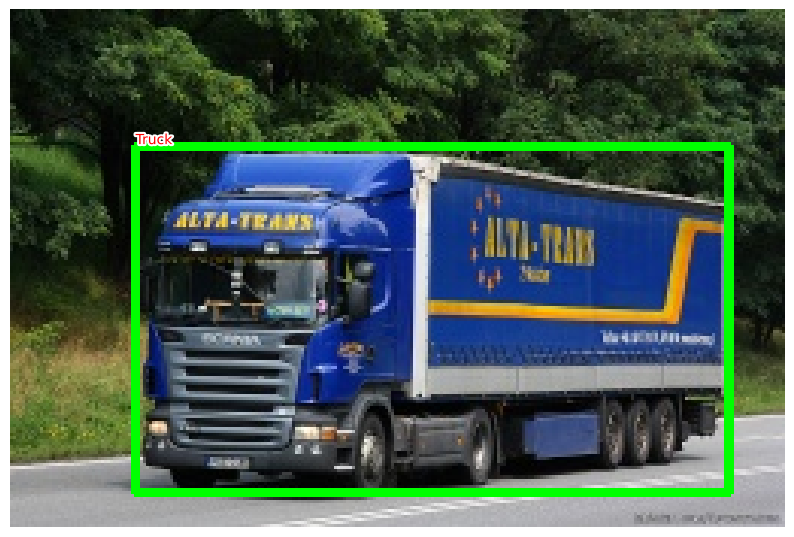

In [63]:
ds = OpenImages(df=DF_RAW)

img, bbs, clss, _ = ds[9]

show(img, bbs=bbs, texts=clss, sz=10)

In [64]:
def extract_candidates(img):
    img_lbl,regions = selectivesearch.selective_search(img, \
    scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

### Fetching region proposals and the gound truth of offset

- FPATHS: store file paths
- GTBBS: ground truth bounding box
- CLSS: classes
- DELTAS: the delta offset of a bounding box with region proposals
- ROIS: region proposal locations
- IOUS: IoU of regions proposals with ground truths

In [65]:

FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]


N = 500

for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if (ix == N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x, y, x + w, y + h) \
                        for x, y, w, h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for \
                    candidate in candidates] for _bb_ in bbs]).T

    for jx, candidate in enumerate(candidates):
        cx, cy, cX, cY = candidate
        candidate_ious = ious[jx]
        
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x, _y, _X, _Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) /\
        np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
    FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
    FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in \
        [FPATHS, GTBBS, \
        CLSS, DELTAS, ROIS]]
    
    targets = pd.DataFrame(flatten(CLSS), columns=['label'])
    label2target = {l:t for t,l in \
    enumerate(targets['label'].unique())}
    target2label = {t:l for l,t in label2target.items()}
    background_class = label2target['background']


### Creating the training data

In [66]:
normalize= transforms.Normalize(mean=[0.485, 0.456, 0.406], \
    std=[0.229, 0.224, 0.225])

def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    return img.to(device).float()

def decode(_y):
    _, preds = _y.max(-1)
    return preds

class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image,crops,bbs,labels,deltas,gtbbs,fpath
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas =[],[],[],[],[]
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, \
                image_deltas, image_gt_bbs, \
                image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) \
                    for crop in crops]
            crops = [preprocess_image(crop/255.)[None] \
                    for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] \
                for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas


In [67]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], \
    CLSS[:n_train], DELTAS[:n_train], \
    GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], \
    CLSS[n_train:], DELTAS[n_train:], \
    GTBBS[n_train:])
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, \
    collate_fn=train_ds.collate_fn, \
    drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, \
    collate_fn=test_ds.collate_fn, \
    drop_last=True)


### R-CNN network architecture

1. Define a VGG backbone
2. Fetch the features post passing the normalized crop through a pretrained model
3. Attach a linear layer with sigmoid activation to the VGG backbone to predict the class corrsponding to the region proposal
4. Attach an additional linear layer to predict the four bounding box offsets.
5. Define the loss calculations for each of the two outputs (one to predict class and the other to predict the four bounding box offsets).
6. Train the model that predicts both the class of region proposal and the four bounding box offsets.

In [68]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()

for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, 
                                   len(label2target))
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Tanh()
        )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels !=0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb *\
                regression_loss, detection_loss.detach(), \
                regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb *\
                regression_loss, detection_loss.detach(), \
                regression_loss

def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas,
                                          clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss,\
        accs.cpu().numpy()
        

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss, _deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas,\
                                                clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, \
        accs.cpu().numpy()


rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)
        
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss,regr_loss,accs = train_batch(inputs, \
                                    rcnn, optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), \
                    trn_loc_loss=loc_loss, \
                    trn_regr_loss=regr_loss, \
                    trn_acc=accs.mean(), end='\r')
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, \
        accs = validate_batch(inputs, rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), \
            val_loc_loss=loc_loss, \
            val_regr_loss=regr_loss, \
            val_acc=accs.mean(), end='\r')
# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

c:\Users\hoang\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hoang\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\hoang/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

KeyboardInterrupt: 

## 9. Fast R-CNN

![](../../../imgs/fast-r-cnn.png)

Các bước của thuật toán này:

1. Cho image qua pretrained model CNN để lấy ra các feature
2. Lấy ra các region proposal của ảnh
3. Lấy ra các feature map area từ các region proposal ( chú ý khi đưa ảnh qua VGG16 thì size ảnh giảm xuống còn 32 và có tất cả 5 pooling operations vì vậy nếu như ảnh ban đầu có bounding box là (40, 32, 200, 240) thì feature map corresponding to the bounding box là (5, 4, 25, 30))
4. Đưa các features map của các region proposals qua Roi pooling layer tức là thực hiện cùng một lúc Roi và pooling để các features map có cùng size (đây là thay thế cho `warping` techniques dùng trong R-CNN).
5. Đứa RoI pooling layer output qua FC layer
6. Train model để dự đoán class và offset của bounding box cho các region proposals

**Chú ý:** Điểm khác biệt lớn nhất giữa R-CNN và Fast R-CNN đó là việc R-CNN chia tách ra các region proposal rồi mới cho đi qua CNN để thực hiện features map còn Fast R-CNN thì lại cho ảnh qua features map rồi thực hiện region proposal trên các features map